In [1]:

import pandas as pd

from utils.timeutil import YearMonth

hst = pd.read_csv(".cache/historical_data.csv", dtype={"code": str})
hst["매수년월"] = hst["매수년월"].apply(lambda x: YearMonth.from_string(x))
hst["매도년월"] = hst["매도년월"].apply(lambda x: YearMonth.from_string(x))
hst = hst[hst["확정실적"].notna()]

In [2]:
import pandas as pd

data = hst.dropna()

x_columns = [
    "O_QoQ_pct",
    "O/EQ_QoQ_pct",
    "O/A_QoQ_pct",
    "E/EQ_QoQ_pct",
    "E_QoQ_pct",
    "EBT_QoQ_pct",
    "E/A_QoQ_pct",
    "EQ/P_pct",
    "EBT/A_QoQ_pct",
    "EBT/EQ_QoQ_pct",
    "GP/P_pct",
    "GP/EQ_QoQ_pct",
    "GP_QoQ_pct",
    "GP/A_QoQ_pct",
    "R/P_pct",
    "R_QoQ_pct",
    "R/A_QoQ_pct",
    "R/EQ_QoQ_pct",
    "GP/EQ_pct",
    "GP/A_pct",
    "EBT/R_pct",
    "O/R_pct",
    "E/EQ_pct",
    "EBT/A_pct",
    "R/A_pct",
    "E/A_pct",
    "O/EQ_pct",
    "EBT/EQ_pct",
    "E/R_pct",
    "O/P_pct",
    "GP/R_pct",
    "O/A_pct",
    "R/EQ_pct",
    "EBT/P_pct",
    "E/P_pct"
]

X = data[x_columns]
y = data["수익률_pct"]

X_train = X.loc[data[data["매도년월"] < YearMonth(2023, 7)].index]
y_train = y.loc[data[data["매도년월"] < YearMonth(2023, 7)].index]

X_test = X.loc[data[data["매도년월"] >= YearMonth(2023, 7)].index]

In [3]:
from sklearn.tree import DecisionTreeRegressor

# 의사결정트리 모델 생성
tree_model = DecisionTreeRegressor(
    max_depth=30,
    max_leaf_nodes=30,
)

# 모델 훈련
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=30, max_leaf_nodes=30)

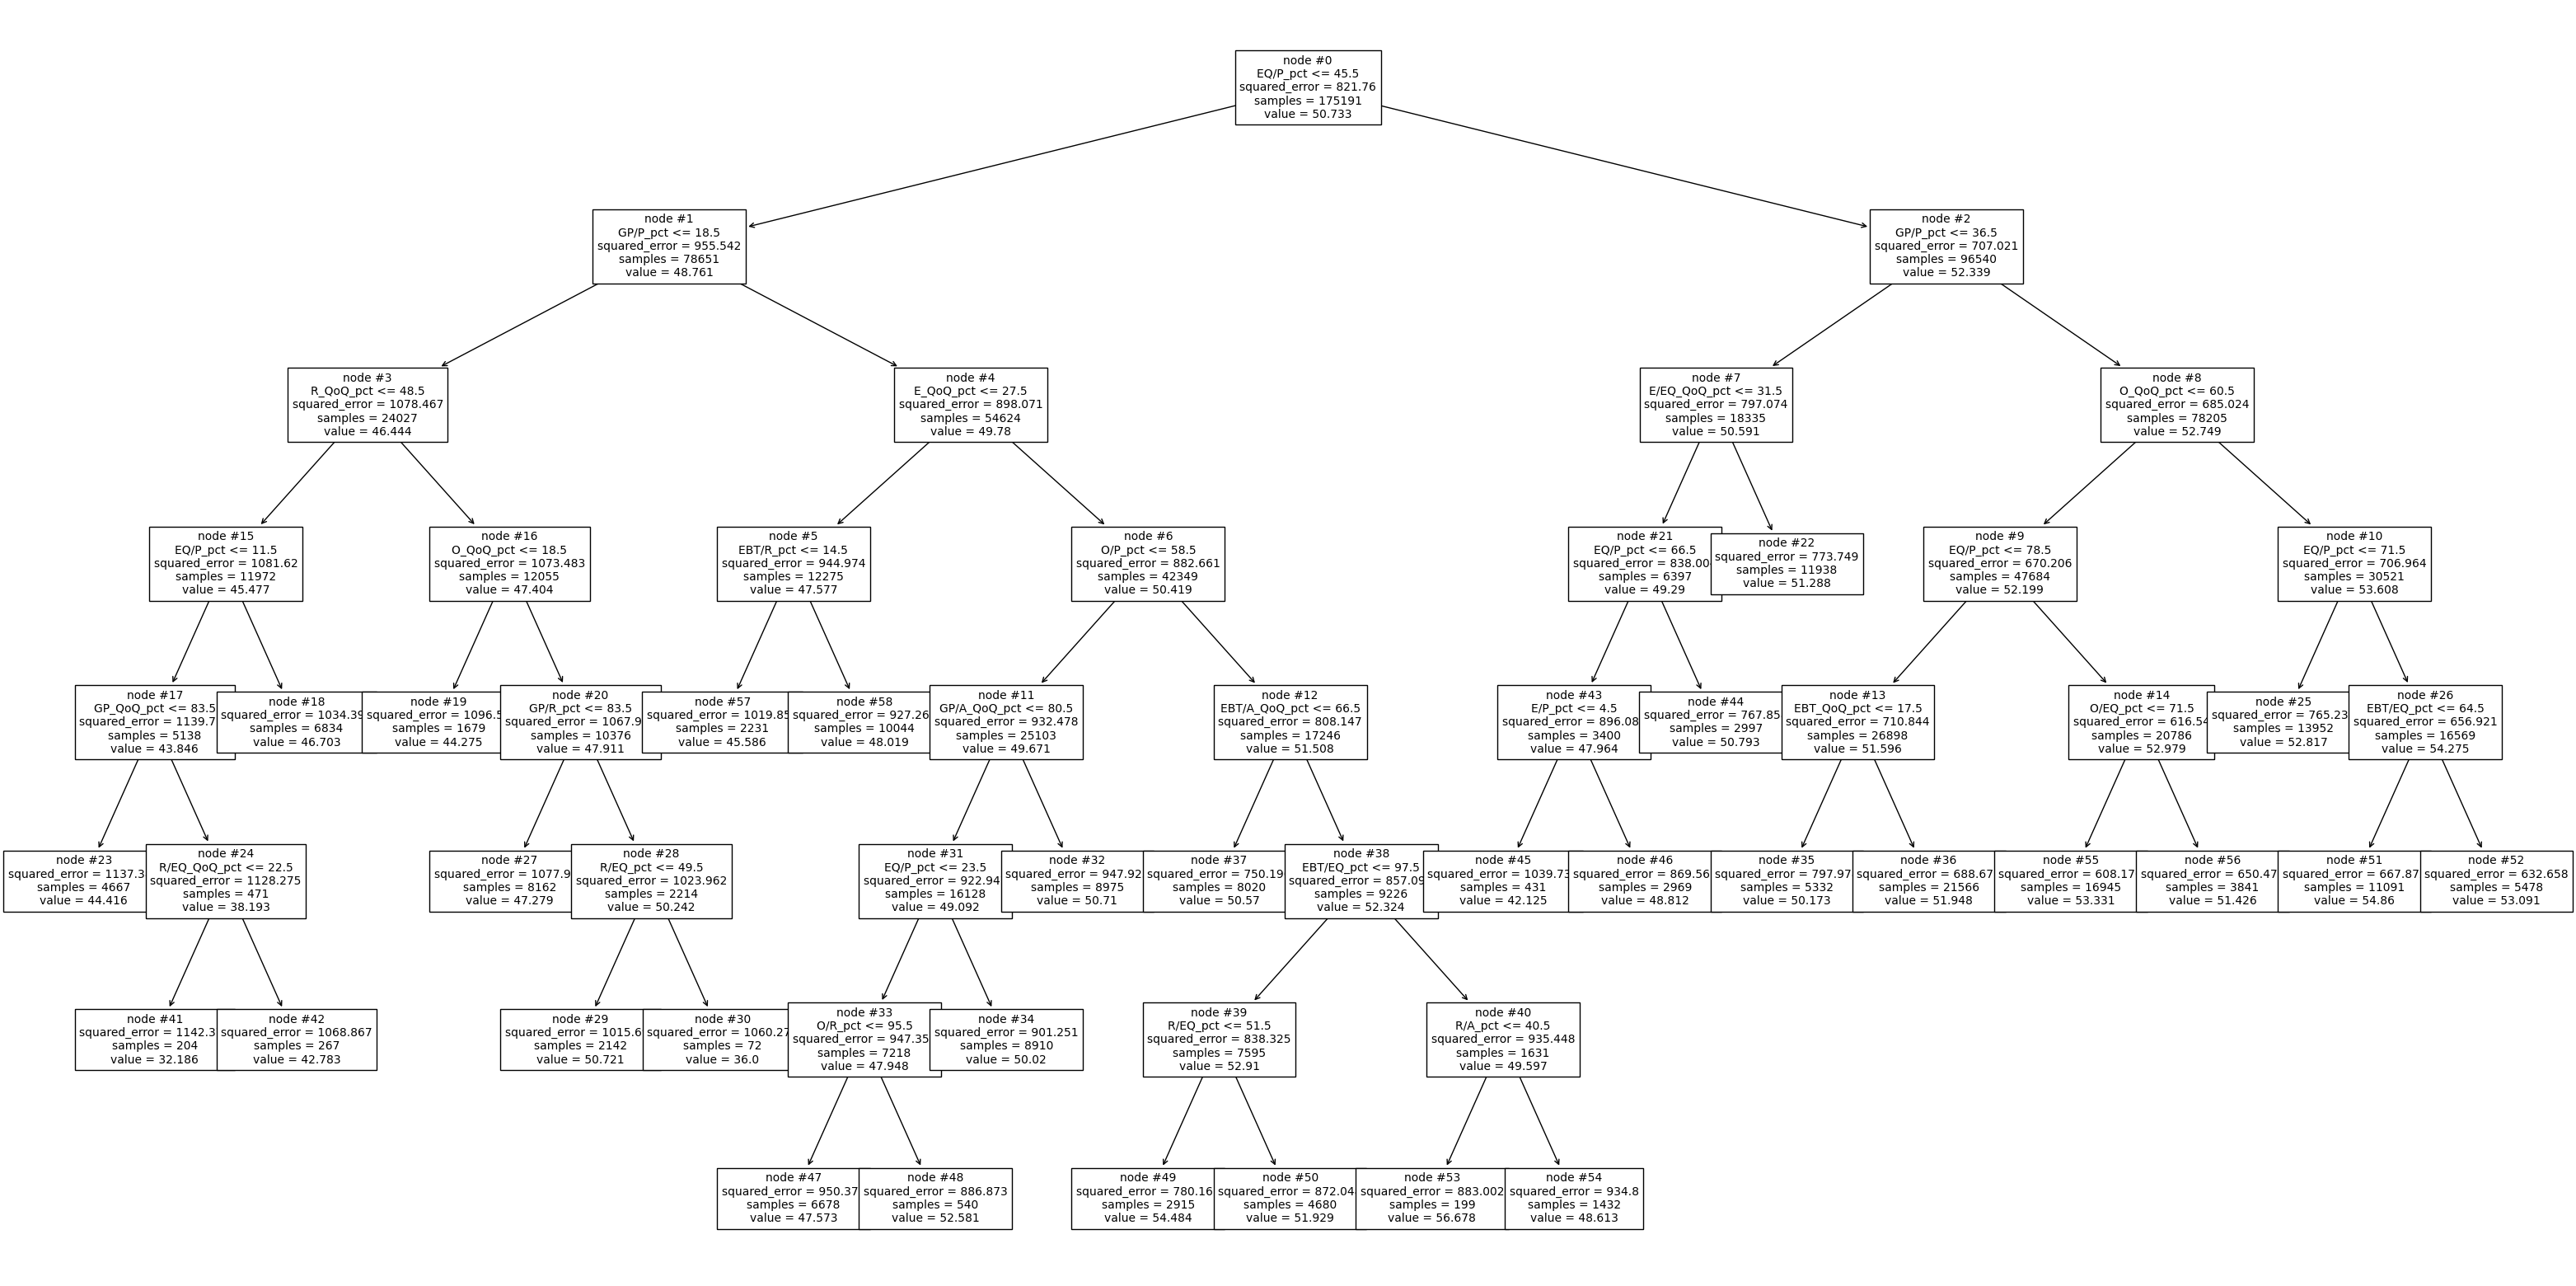

In [4]:

from matplotlib import pyplot as plt

from sklearn import tree

plt.figure(figsize=(40, 20))
tree.plot_tree(tree_model, fontsize=10, node_ids=True, feature_names=X_train.columns)
plt.show()

In [5]:
data1 = data[[
    "매수년월", "매도년월", "종목명",
    "수익률_pct", "수익률"
]].reindex(X_test.index)

p = tree_model.predict(X_test)
p = pd.Series(p)
p.name = "pred"
p.index = data1.index
data1 = data1.join(p)
data1 = data1.join(pd.Series(tree_model.apply(X_test), index=data1.index, name="node_index"))

In [6]:
data1

,매수년월,매도년월,종목명,수익률_pct,수익률,pred,node_index
232316,2023-06,2023-07,동화약품,60.0,-0.041386,52.816514,25
232317,2023-06,2023-07,KR모터스,14.0,-0.141892,50.019753,34
232318,2023-06,2023-07,경방,64.0,-0.033199,53.330599,55
232319,2023-06,2023-07,삼양홀딩스,75.0,-0.002755,53.330599,55
232320,2023-06,2023-07,하이트진로,52.0,-0.060185,50.569825,37
...,...,...,...,...,...,...,...
254843,2024-02,2024-03,윙입푸드,98.0,0.375991,53.091457,52
254844,2024-02,2024-03,엑세스바이오,29.0,-0.043590,53.330599,55
254845,2024-02,2024-03,잉글우드랩,72.0,0.033003,51.929274,50
254846,2024-02,2024-03,코오롱티슈진,96.0,0.295000,50.720822,29


In [7]:
port = data1.groupby("매수년월").apply(
    lambda x: x.sort_values(by="pred", ascending=False).nlargest(30, columns=["pred"])).reset_index(drop=True)
port

/var/folders/bk/_r_dhfm12k54q_k0r83m0fkc0000gn/T/ipykernel_86348/2973856451.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  port = data1.groupby("매수년월").apply(


,매수년월,매도년월,종목명,수익률_pct,수익률,pred,node_index
0,2023-06,2023-07,피엔티,98.0,0.451852,56.678392,53
1,2023-06,2023-07,매커스,44.0,-0.074415,56.678392,53
2,2023-06,2023-07,LX하우시스,96.0,0.220637,54.859526,51
3,2023-06,2023-07,우성,48.0,-0.067245,54.859526,51
4,2023-06,2023-07,원림,54.0,-0.055319,54.859526,51
...,...,...,...,...,...,...,...
265,2024-02,2024-03,SK케미칼,14.0,-0.082474,54.859526,51
266,2024-02,2024-03,동아엘텍,96.0,0.292826,54.859526,51
267,2024-02,2024-03,우진비앤지,42.0,-0.022414,54.859526,51
268,2024-02,2024-03,베뉴지,44.0,-0.019048,54.859526,51


In [8]:
port.groupby("매수년월")["수익률"].mean()

매수년월
2023-06   -0.023776
2023-07   -0.007204
2023-08   -0.016413
2023-09   -0.037282
2023-10    0.086293
2023-11    0.011257
2023-12   -0.007750
2024-01    0.014416
2024-02   -0.011342
Name: 수익률, dtype: float64

In [9]:
(port.groupby("매수년월")["수익률"].mean() + 1).prod() - 1

0.003259185735624781

In [10]:

def print_node_path(node, depth=0, path=[]):
    if node == -1:
        return
    # 노드의 기준 정보
    left_child = tree_model.tree_.children_left[node]
    right_child = tree_model.tree_.children_right[node]
    feature = tree_model.tree_.feature[node]
    threshold = tree_model.tree_.threshold[node]

    # 현재 노드의 기준을 경로에 추가
    if feature != -2:  # leaf node가 아니라면
        path.append((feature, threshold, depth))

    # 잎 노드 처리
    if left_child == -1 and right_child == -1:
        conditions = []
        for feat, thres, dep in path:
            conditions.append(f"{x_columns[feat]} <= {thres}")

        print(f"Leaf node at depth {depth}: Path conditions: {' AND '.join(conditions)}")
    else:
        # 왼쪽 자식 노드 방문
        print_node_path(left_child, depth + 1, path.copy())
        # 오른쪽 자식 노드 방문
        print_node_path(right_child, depth + 1, path.copy())


print_node_path(0)

Leaf node at depth 5: Path conditions: EQ/P_pct <= 45.5 AND GP/P_pct <= 18.5 AND R_QoQ_pct <= 48.5 AND EQ/P_pct <= 11.5 AND GP_QoQ_pct <= 83.5
Leaf node at depth 6: Path conditions: EQ/P_pct <= 45.5 AND GP/P_pct <= 18.5 AND R_QoQ_pct <= 48.5 AND EQ/P_pct <= 11.5 AND GP_QoQ_pct <= 83.5 AND R/EQ_QoQ_pct <= 22.5
Leaf node at depth 6: Path conditions: EQ/P_pct <= 45.5 AND GP/P_pct <= 18.5 AND R_QoQ_pct <= 48.5 AND EQ/P_pct <= 11.5 AND GP_QoQ_pct <= 83.5 AND R/EQ_QoQ_pct <= 22.5
Leaf node at depth 4: Path conditions: EQ/P_pct <= 45.5 AND GP/P_pct <= 18.5 AND R_QoQ_pct <= 48.5 AND EQ/P_pct <= 11.5
Leaf node at depth 4: Path conditions: EQ/P_pct <= 45.5 AND GP/P_pct <= 18.5 AND R_QoQ_pct <= 48.5 AND O_QoQ_pct <= 18.5
Leaf node at depth 5: Path conditions: EQ/P_pct <= 45.5 AND GP/P_pct <= 18.5 AND R_QoQ_pct <= 48.5 AND O_QoQ_pct <= 18.5 AND GP/R_pct <= 83.5
Leaf node at depth 6: Path conditions: EQ/P_pct <= 45.5 AND GP/P_pct <= 18.5 AND R_QoQ_pct <= 48.5 AND O_QoQ_pct <= 18.5 AND GP/R_pct <= 8